In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = pd.read_csv('results_sharpe/all_sharpe_ratio.csv')
results = results.rename(columns={"3f_rnn": "rnn_3f", "4f_rnn": "rnn_4f", "5f_rnn": "rnn_5f"})

df = pd.read_csv("df_ff_factors_010225.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')

df['date'] = pd.to_datetime(df['date']) # converting to date format
dataset = df.sort_values(by='date')[['crsp_fundno','date','rolling_sharpe']]
merged_df = pd.merge(results, dataset, how='left',on='rolling_sharpe').drop(columns='Unnamed: 0')
merged_df_no_id = merged_df.drop(columns=['crsp_fundno'])
merged_df_no_id = merged_df_no_id.set_index('date')
feature_cols = [col for col in merged_df_no_id.columns if col not in ['rolling_sharpe']]

agg_metrics = pd.read_csv("results_sharpe/sharpe_ratio_metrics_results_with_rnn.csv")

In [5]:
merged_df_test = merged_df.drop(columns='date')
merged_df_test
fund_performance = merged_df_test.groupby('crsp_fundno')['rolling_sharpe'].mean().reset_index()

# Rank funds based on actual performance
fund_performance['rank'] = fund_performance['rolling_sharpe'].rank(ascending=False, method='first')

# Find the top 10% of funds
decile_cutoff = np.ceil(len(fund_performance) * 0.1).astype(int)
top_decile_funds = fund_performance.nsmallest(decile_cutoff, 'rank')
bottom_decile_funds = fund_performance.nlargest(decile_cutoff, 'rank')
# top_decile_funds['crsp_fundno']

top_performing_funds = merged_df[merged_df['crsp_fundno'].isin(top_decile_funds['crsp_fundno'])]
top_performing_funds_no_id = top_performing_funds.drop(columns=['crsp_fundno']).set_index('date')
worst_performing_funds = merged_df[merged_df['crsp_fundno'].isin(bottom_decile_funds['crsp_fundno'])]
worst_performing_funds_no_id = worst_performing_funds.drop(columns=['crsp_fundno']).set_index('date')
# top_performing_funds_no_id
# top_performing_funds
# merged_df
# top_performing_funds_no_id
# worse_performing_funds_no_id

In [7]:
# Generation of Error Metrics
def mean_absolute_scaled_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae = mean_absolute_error(y_true, y_pred)
    mase = mae / naive_mae if naive_mae != 0 else np.nan

    return mase 

# def naive_renamer(df):
#     df['naive_3f'] = df['naive']
#     df['naive_4f'] = df['naive']
#     df['naive_5f'] = df['naive']
#     df = df.drop(columns='naive')
#     return df

def metrics_generator(df, metric):
    if metric == 'MASE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_scaled_error(group['rolling_sharpe'], group[col]) for col in feature_cols
            })
        )
    elif metric == 'MAE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_error(group['rolling_sharpe'], group[col]) for col in feature_cols
            })
        )
    elif metric == 'R2':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: max(r2_score(group['rolling_sharpe'], group[col]), -2) for col in feature_cols
            })
        )
    elif metric == 'MSE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_squared_error(group['rolling_sharpe'], group[col]) for col in feature_cols
            })
        )
    else:
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: np.sqrt(mean_squared_error(group['rolling_sharpe'], group[col])) for col in feature_cols
            })
        )
    return final_df

mase_results = metrics_generator(merged_df_no_id, metric = 'MASE')
mae_results = metrics_generator(merged_df_no_id, metric = 'MAE')
r2_results = metrics_generator(merged_df_no_id, metric = 'R2')
mse_results = metrics_generator(merged_df_no_id, metric = 'MSE')
rmse_results = metrics_generator(merged_df_no_id, metric = 'RMSE')

# mase_results = metrics_generator(top_performing_funds_no_id, metric = 'MASE')
# mae_results = metrics_generator(top_performing_funds_no_id, metric = 'MAE')
# r2_results = metrics_generator(top_performing_funds_no_id, metric = 'R2')
# mse_results = metrics_generator(top_performing_funds_no_id, metric = 'MSE')
# rmse_results = metrics_generator(top_performing_funds_no_id, metric = 'RMSE')

# mase_results = metrics_generator(worst_performing_funds_no_id, metric = 'MASE')
# mae_results = metrics_generator(worst_performing_funds_no_id, metric = 'MAE')
# r2_results = metrics_generator(worst_performing_funds_no_id, metric = 'R2')
# mse_results = metrics_generator(worst_performing_funds_no_id, metric = 'MSE')
# rmse_results = metrics_generator(worst_performing_funds_no_id, metric = 'RMSE')

In [8]:
rmse_results

,linear_3f,linear_4f,linear_5f,ffnn_3f,ffnn_4f,ffnn_5f,rf_3f,rf_4f,rf_5f,rnn_3f,rnn_4f,rnn_5f
date,,,,,,,,,,,,
2019-03-29,1.164503,1.165975,1.241549,0.249549,0.269097,0.232998,0.254084,0.306387,0.215989,0.330848,0.324616,0.282281
2019-04-30,0.879413,0.888640,0.843473,0.755671,0.619326,0.688626,0.569608,0.516994,0.340176,0.771374,0.901782,0.626060
2019-05-31,1.593034,1.585473,1.820491,1.734386,1.541773,1.835336,0.744985,0.715672,0.850892,1.238995,1.019967,1.322766
2019-06-28,0.444838,0.506475,0.327490,0.287231,0.293310,0.745951,0.572884,0.556759,0.449061,0.598913,0.588205,0.750099
2019-07-31,1.228609,1.189799,1.136445,0.269851,0.380007,0.177898,0.340542,0.326853,0.300087,0.203480,0.177928,0.211623
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,0.397309,0.353869,0.405543,0.452945,0.584413,0.964661,0.260294,0.266445,0.318762,0.205669,0.367840,0.237236
2024-04-30,0.325290,0.311096,0.373090,0.428815,0.392355,0.677756,0.223472,0.233826,0.235695,0.278489,0.248294,0.290435
2024-05-31,0.483635,0.428660,0.519993,0.339024,0.301336,0.566150,0.302130,0.304314,0.298941,0.509204,0.481508,0.400198


Metric Plots by Time

In [10]:
import matplotlib.pyplot as plt

# Single Plot
def plotter_fn(df, suffix, ax, legend_handles, metric):
    # Define mapping of model keywords to labels
    label_mapping = {'naive': 'Naive', 'linear': 'LR', 'ffnn': 'NN1', 'rf': 'RF', 'rnn': 'RNN'}
    color_list = {'Naive': 'purple', 'LR': 'gold', 'NN1': 'lightseagreen', 'RF': 'navy', 'RNN': 'crimson'}
    factor_list = {'_3f': '3-Factor', '_4f': '4-Factor', '_5f': '5-Factor'}

    # Select columns with the specified suffix
    cols = [col for col in df.columns if suffix in col]
    new_df = df[cols]

    for col in new_df.columns:
        # Assign the appropriate label based on column name
        label = next((label_mapping[key] for key in label_mapping if key in col), col)
        color = color_list.get(label, 'black')  # Default color if not in color_list
        line, = ax.plot(new_df.index, new_df[col], label=label, color=color)

        # Store legend handles if not already added
        if label not in legend_handles:
            legend_handles[label] = line

    # Formatting the plot
    ax.set_ylabel(metric, size=32)
    if suffix == '_5f':
        ax.set_xlabel("Date", size=32)
    ax.set_title(f"{factor_list[suffix]}", fontsize=32)
    ax.tick_params(axis='x', labelsize = 28, pad=10) 
    ax.tick_params(axis='y', labelsize = 28)
    ax.grid(False)  # Remove grid lines
    ax.legend().set_visible(False)  # Remove legends from individual plots
    if metric == 'MASE':
        ax.set_ylim(0, 5)
    elif metric == 'RMSE':
        ax.set_ylim(0, 4)
    elif metric == 'MSE':
        ax.set_ylim(0, 10)
    elif metric == 'R2':
        ax.set_ylim(-2, 1)

def overall_plotter(giant_df,metric):
    fig, axes = plt.subplots(3, 2, figsize=(16, 16), gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios':[1,0.1]}, sharex=True,sharey=True)

    legend_handles = {}

    # Drop the naive columns before plotting
    giant_df_without_naive = giant_df.drop(columns=["naive_3f", "naive_4f", "naive_5f"])

    # Plot for each model type
    for i, suffix in enumerate(["_3f", "_4f", "_5f"]):
        plotter_fn(giant_df_without_naive, suffix, axes[i,0], legend_handles, metric)

    # Create a blank 4th subplot for the legend
    axes[0,1].axis("off")  # Remove axes
    axes[2,1].axis("off")  # Remove axes
    axes[1,1].axis("off")  # Remove axes
    axes[1,1].legend(legend_handles.values(), legend_handles.keys(), title="Models", loc="center")
    axes[1,1].legend(
        legend_handles.values(),
        legend_handles.keys(),
        title="Models",
        loc="center",
        fontsize=24,  # Increase legend text size
        title_fontsize=28  # Increase legend title size
    )

    plt.suptitle(
        f"{metric.upper()} of Sharpe Ratio Across Models",
        fontsize=28,
        fontweight="bold",
        y=0.99,  # Adjust vertical position
    )

    # Show plot
    plt.tight_layout()
    plt.show()

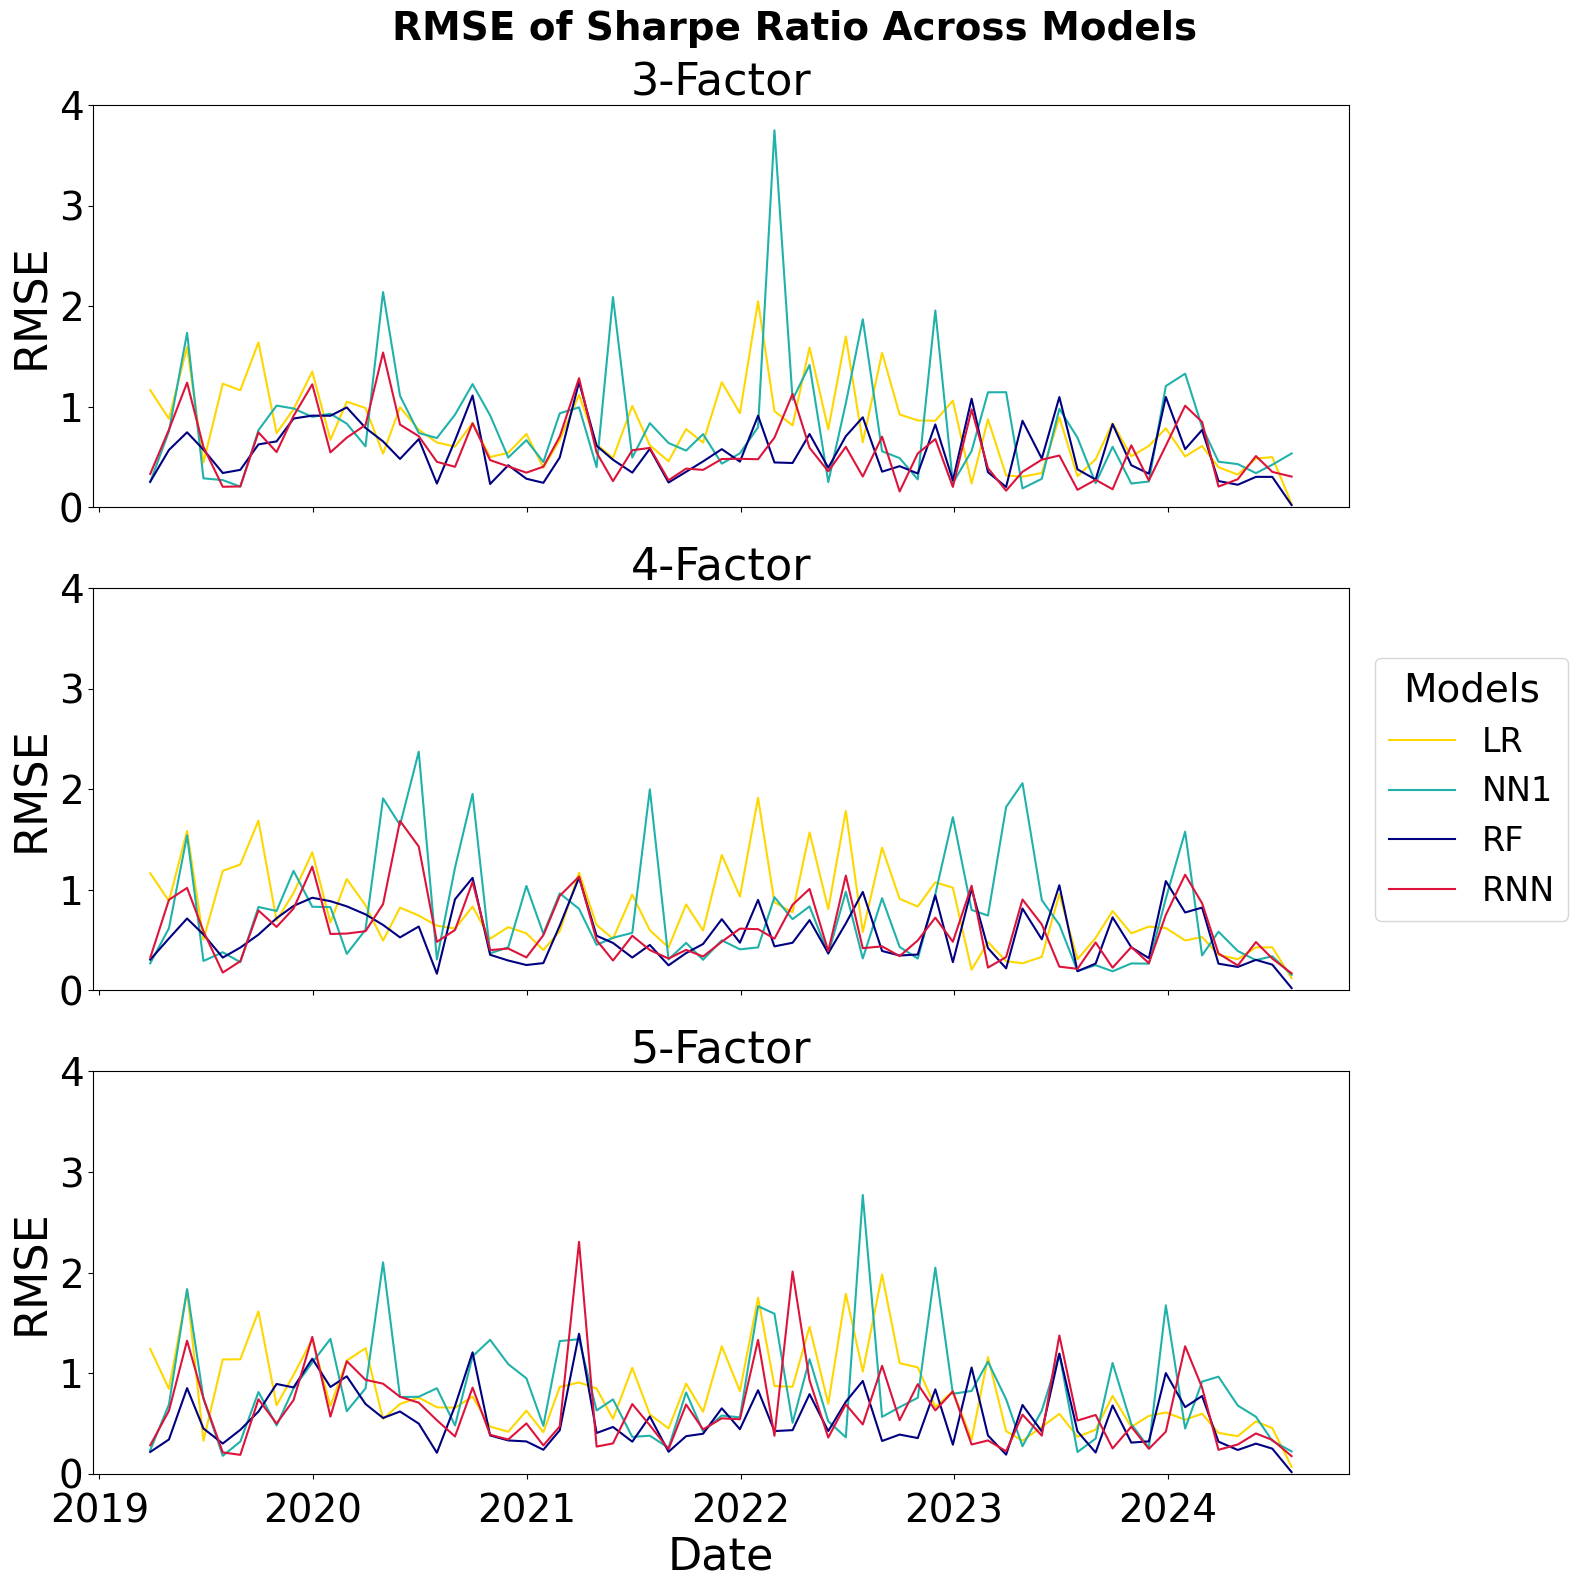

In [11]:
overall_plotter(rmse_results,'RMSE')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def agg_bar_plots_grouped(results, metrics):
    # Extract models and MASE values
    results = results.copy()
    results['Group'] = results['Model'].str.extract(r'_(\df)$')  # Extract "3f", "4f", "5f"
    results['Model'] = np.where(results['Model'].str.contains('ffnn'), 'NN1', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('rf'), 'RF', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('linear'), 'LR', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('naive'), 'Naive', results['Model'])
    # return results
    # Sort by group (_3f, _4f, _5f)
    results = results.sort_values(by="Group")

    models = list(results['Model'])
    mase = list(results[metrics])

    color_list = {'Naive': 'crimson', 'LR': 'gold', 'NN1': 'lightseagreen', 'RNN': 'cornflowerblue', 'RF': 'navy'}
    colors = [
        color_list['Naive'] if 'Naive' in model else
        color_list['LR'] if 'LR' in model else
        color_list['NN1'] if 'NN1' in model else
        color_list['RNN'] if 'RNN' in model else
        color_list['RF']
        for model in models
    ]
    
    # Create x positions with gaps
    groups = sorted(set(results['Group']))  # ['3f', '4f', '5f']
    x_positions = []
    group_midpoints = {}
    current_x = 0
    group_gap = 2  # Space between groups
    bar_spacing = 0.8  # Adjust this to control spacing **within** groups (try 0.3, 0.2)

    for group in groups:
        group_models = results[results['Group'] == group]['Model']
        # Reduce spacing within groups using np.linspace
        x_pos = np.linspace(current_x, current_x + (len(group_models) - 1) * bar_spacing, len(group_models))
        x_positions.extend(x_pos)
        group_midpoints[group] = np.mean(x_pos)
        current_x += (len(group_models) - 1) * bar_spacing + group_gap  # Add gap after each group
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(x_positions, mase, color=colors, alpha=0.8)
    plt.xticks(x_positions, models, rotation=0, fontsize=10)
    
    # patterns = ['x', 'o', 'O', '.', 'x', 'o', 'O', '.', 'x', 'o', 'O', '.', '.', '*', 'x', 'o', 'O', '.', '*']
    # for i, bar in enumerate(bars):
    #     bar.set_hatch(patterns[i % len(patterns)])
    
    plt.title(f'{metrics} for 1-Step Horizon', fontsize=12)
    plt.xlabel("Models", fontsize=10, labelpad=20)
    plt.ylabel(f'{metrics}', fontsize=10)
    factor_labels = {"3f": "3-Factor", "4f": "4-Factor", "5f": "5-Factor"}
    if metrics == 'RMSE':
        pad = -0.14
    elif metrics == 'R2':
        pad = -0.2
        plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3)
    elif metrics == 'MASE':
        pad = -0.125
    elif metrics == 'MSE':
        pad = -0.2
    else:
        pad = -0.08
    for group, midpoint in group_midpoints.items():
        plt.text(midpoint, pad, factor_labels[group], fontsize=12, ha='center')
    plt.show()

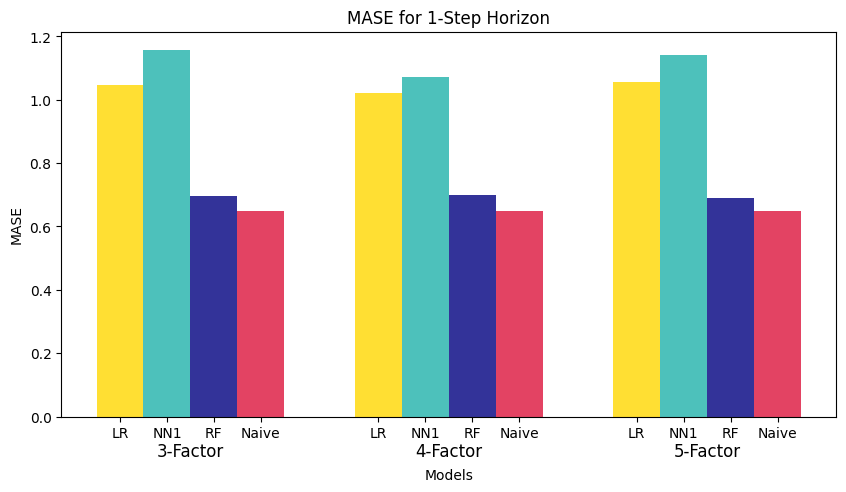

In [13]:
agg_bar_plots_grouped(agg_metrics, 'MASE')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
y = pd.read_csv("sharpe_ratio_metrics_results.csv")

def agg_bar_plots_grouped(results, metrics):
    # Extract models and MASE values
    results = results.copy()
    results['Group'] = results['Model'].str.extract(r'_(\df)$')  # Extract "3f", "4f", "5f"
    results['Model'] = np.where(results['Model'].str.contains('ffnn'), 'NN1', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('rf'), 'RF', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('linear'), 'LR', results['Model'])
    results['Model'] = np.where(results['Model'].str.contains('naive'), 'Naive', results['Model'])
    # Sort by group (_3f, _4f, _5f)
    results = results.sort_values(by="Group")

    models = list(results['Model'])
    mase = list(results[metrics])

    color_list = {'Naive': 'crimson', 'LR': 'gold', 'NN1': 'lightseagreen', 'RNN': 'cornflowerblue', 'RF': 'navy'}
    colors = [
        color_list['Naive'] if 'Naive' in model else
        color_list['LR'] if 'LR' in model else
        color_list['NN1'] if 'NN1' in model else
        color_list['RNN'] if 'RNN' in model else
        color_list['RF']
        for model in models
    ]

    # Create x positions with gaps
    groups = sorted(set(results['Group']))  # ['3f', '4f', '5f']
    x_positions = []
    group_midpoints = {}
    current_x = 0
    group_gap = 2  # Space between groups
    bar_spacing = 0.8  # Adjust this to control spacing **within** groups (try 0.3, 0.2)

    for group in groups:
        group_models = results[results['Group'] == group]['Model']
        # Reduce spacing within groups using np.linspace
        x_pos = np.linspace(current_x, current_x + (len(group_models) - 1) * bar_spacing, len(group_models))
        x_positions.extend(x_pos)
        group_midpoints[group] = np.mean(x_pos)
        current_x += (len(group_models) - 1) * bar_spacing + group_gap  # Add gap after each group
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(x_positions, mase, color=colors, alpha=0.8)
    plt.xticks(x_positions, models, rotation=0, fontsize=10)
    
    # patterns = ['x', 'o', 'O', '.', 'x', 'o', 'O', '.', 'x', 'o', 'O', '.', '.', '*', 'x', 'o', 'O', '.', '*']
    # for i, bar in enumerate(bars):
    #     bar.set_hatch(patterns[i % len(patterns)])
    
    plt.title(f'{metrics} for 1-Step Horizon', fontsize=12)
    plt.xlabel("Models", fontsize=10, labelpad=20)
    plt.ylabel(f'{metrics}', fontsize=10)
    factor_labels = {"3f": "3-Factor", "4f": "4-Factor", "5f": "5-Factor"}
    if metrics == 'RMSE':
        pad = -0.14
    elif metrics == 'R2':
        pad = -0.2
        plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3)
    elif metrics == 'MASE':
        pad = -0.125
    elif metrics == 'MSE':
        pad = -0.2
    else:
        pad = -0.08
    for group, midpoint in group_midpoints.items():
        plt.text(midpoint, pad, factor_labels[group], fontsize=12, ha='center')
    plt.show()

agg_bar_plots_grouped(y, 'MAE')

# Example Usage:
# plt.bar(y, width=0.8, label="3-Factor", color='red', alpha=0.7)